Text(0.5, 1.0, 'original cover image')

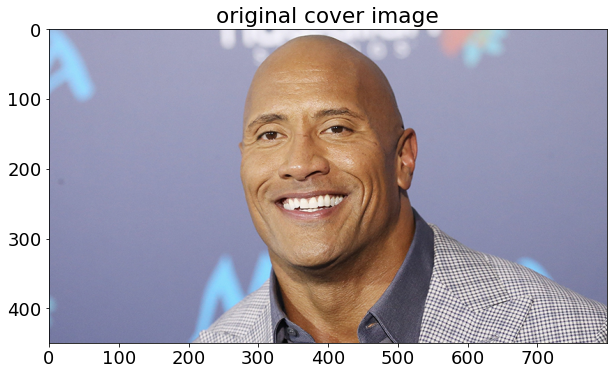

In [1]:
from matplotlib.image import imread
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size':18})

# creating a object 
# PATH = "ImageSources\\jfif\\darth_vader.jfif"
PATH = "ImageSources\\jfif\\the_rock.jfif"
# PATH = "ImageSources\\jfif\\obi-wan_kenobi.jfif"
image = Image.open(PATH)
image.load()
Rot, Grün, Blau= image.split() #split image into its RGB channels
cover_cols, cover_rows = image.size

plt.figure()
plt.imshow(image)
plt.title("original cover image")

In [2]:
string="""It's about drive, it's about power
We stay hungry, we devour
Put in the work, put in the hours and take what's ours (ahoo)
Black and Samoan in my veins
My culture bangin' with Strange
I change the game, so what's my motherfuckin' name (Rock)
(What they gonna get though?)
Desecration, defamation, if you wanna bring it to the masses
Face to face, now we escalatin', when I have to put boots to asses
Mean on ya, like a dream when I'm rumblin', you're gonna scream mama
So bring drama to the King Brahma (then what?) 
Comin' at you with extreme mana"""


""" string version """
def text_to_bits(text, encoding='utf-8', errors='surrogatepass'):
    bits = bin(int.from_bytes(text.encode(encoding, errors), 'big'))[2:]
    return bits.zfill(8 * ((len(bits) + 7) // 8))

def text_from_bits(bits, encoding='utf-8', errors='surrogatepass'):
    n = int(bits,2)
    return n.to_bytes((n.bit_length() + 7) // 8, 'big').decode(encoding, errors) or '\0'

    
""" int version """
def text_to_bits_int(text, gain):
    string_bits = text_to_bits(text)
    # convert each char to int
    return [int(i)*gain for i in string_bits]

def text_from_bits_int(bits):
    # convert each element to string
    string_bits = [str(i) for i in bits]
    string_concat = ""
    # concatenate each element to one string
    for string in string_bits:
        string_concat += string
    string_decode = text_from_bits(string_concat)
    return string_decode


bin_encoded =  text_to_bits_int(string, 2000)


print(bin_encoded[:10])
#bin_encoded=[73,116,39,115,32,97 ,98 ,111 ,117 ,116 ,32 ,100 ,114 ,105 ,118 ,101 ,32 ,105 ,116 ,39 ,115 ,32 ,97 ,98 ,111 ,117 ,116 ,32 ,112 ,111, 119 ,101 ,114]
# bin_decoded = text_from_bits_int(bin_encoded)
# print("bin_decoded:", bin_decoded)

# normalize a channel by its max and min values
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

# convert inverse transformed message to parsable binary message
def message2bin(message, threshold):
    digital = np.zeros(len(message)).astype('uint8')
    for ix, m in enumerate(message):
        if m > threshold:
            digital[ix] = 1
        else:
            digital[ix] = 0
    return digital


[0, 2000, 0, 0, 2000, 0, 0, 2000, 0, 2000]


fft max absolute value: 54619419.0


C:\Users\maxik\AppData\Local\Temp/ipykernel_29020/3926233585.py:28: RuntimeWarning: divide by zero encountered in log10
  im = Image.fromarray(20*np.log10(cover_r_fft_masked))
C:\Users\maxik\AppData\Local\Temp/ipykernel_29020/3926233585.py:49: RuntimeWarning: divide by zero encountered in log10
  im = Image.fromarray(20*np.log10(cover_r_fft_shift))


max value: 256.3369165529977
max value: 255


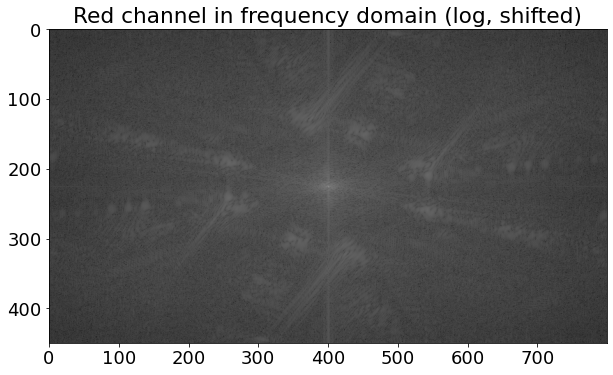

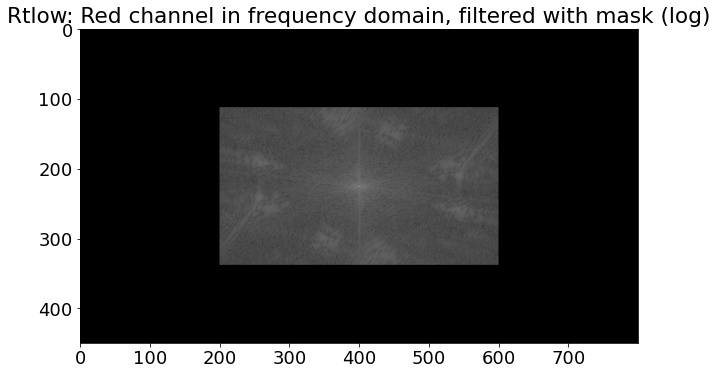

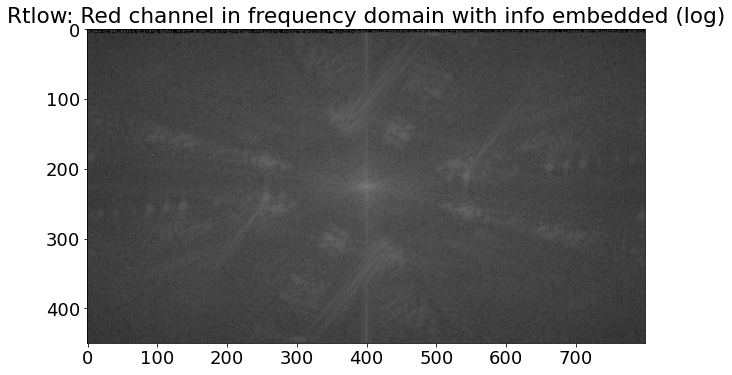

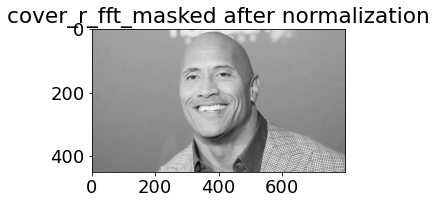

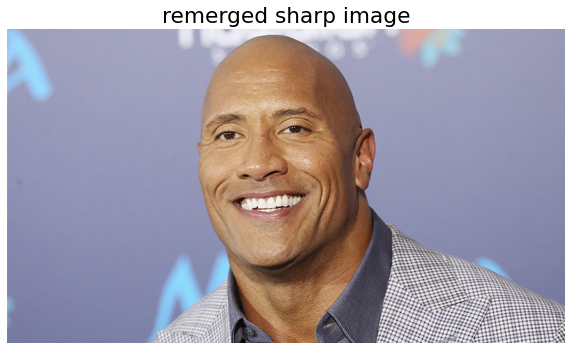

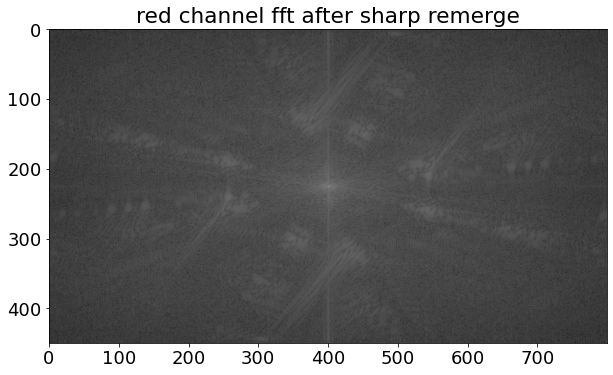

In [4]:
keep=0.5  # 100*(1-keep) is the amount of pixels which will get cut off 

cover_r_fft=np.fft.fft2(Rot)                            #FFT on R Channel
cover_r_fft_abs = np.abs(cover_r_fft)
cover_r_fft_shift = np.fft.fftshift(cover_r_fft_abs)
print("fft max absolute value:", np.max(cover_r_fft_abs))

im = Image.fromarray(20*np.log10(np.fft.fftshift(cover_r_fft_abs)))
plt.figure()
# plt.subplot(121)
plt.imshow(im)
plt.title("Red channel in frequency domain (log, shifted)")

#cut off high frequencies from R channel
cover_r_fft_mask = np.full((cover_rows, cover_cols), False)
row_start = round(cover_rows/2*(1-keep))
row_stop = round(cover_rows/2*(1+keep))
col_start = round(cover_cols/2*(1-keep))
col_stop = round(cover_cols/2*(1+keep))
cover_r_fft_mask[row_start:row_stop, col_start:col_stop] = True  # rectangular
# cover_r_fft_mask_shift = np.fft.fftshift(cover_r_fft_mask)      # cross-like

# plt.figure()
# plt.imshow(cover_r_fft_mask, cmap="gray")
# plt.title("sharp mask")

cover_r_fft_masked = cover_r_fft_shift*cover_r_fft_mask
im = Image.fromarray(20*np.log10(cover_r_fft_masked))
plt.figure()
# plt.subplot(122)
plt.imshow(im)
plt.title("Rtlow: Red channel in frequency domain, filtered with mask (log)")


counter=0
# write hidden message into filtered absolute part
for i in range(cover_rows):
    for j in range(cover_cols):
        # write where coefficients are zero -> previously filtered out.
        if cover_r_fft_mask[i,j]==0:
            if counter<len(bin_encoded):
                # write hidden message inside absolute part by overwriting coefficients where the mask is 0
                cover_r_fft_shift[i,j]=bin_encoded[counter]
                # print(cover_r_fft_abs[i,j])
                counter+=1
          

# plot absolute after embedding information
im = Image.fromarray(20*np.log10(cover_r_fft_shift))
plt.figure()
plt.imshow(im)
plt.title("Rtlow: Red channel in frequency domain with info embedded (log)")
#IFFT on R channel. Take filtered absolute and inverse with original phase, imaginary part should be negligable
cover_r_masked =np.fft.ifft2(np.fft.ifftshift(cover_r_fft_shift)*np.exp(1j*np.angle(cover_r_fft))).real
# print(cover_r_masked)


# plt.subplot(131)
plt.figure()
plt.imshow(cover_r_masked, cmap="gray")
plt.title("cover_r_fft_masked before normalization")
print("max value:", np.max(cover_r_masked))

cover_r_masked_norm = convert(cover_r_masked, 0,255, np.uint8)
plt.subplot(122)
plt.imshow(cover_r_masked_norm, cmap="gray")
plt.title("cover_r_fft_masked after normalization")
print("max value:", np.max(cover_r_masked_norm))
# cover_r_masked_norm = cover_r_masked

# merge layers
cover_reconstructed =  np.stack((cover_r_masked_norm, Grün, Blau), axis=2).astype('uint8')
img = Image.fromarray(cover_reconstructed)     #create image from remerged matrix
plt.figure()
# plt.subplot(133)
plt.axis('off')
plt.imshow(img) #Show picture with embeddes secret message
plt.title("remerged sharp image")


sanity_check = Image.fromarray(20*np.log10(np.abs(np.fft.fftshift(np.fft.fft2(cover_r_masked)))))
plt.figure()
plt.imshow(sanity_check, cmap="gray")
plt.title("red channel fft after sharp remerge")

im = img.save("ImageSources\\Steganograms\\remerged_sharp.png")     #save image as png

max value stego_r:
 255
1237.000000000001
1886.0627212776092
1658.3628566202622
1601.7137785361538
2291.906099082198
1120.2224440745063
1117.3712151106533
2733.123310757329
1101.127085109288
846.2267055204006
1276.32834677533
1394.2980959666352
353.718001012198
816.6028486656154
410.1631744062475
778.7469529644019
551.316472069725
669.3252492710743
922.4376160713934
1232.4575075873802
318.0545741993414
1137.500861279616
2100.725087978448
2039.0441618657421
409.26916741048433
1100.6161007186427
2551.282069577383
2948.1097214760453
578.6238014808301
838.6136547323043
4185.654534451057
3290.520834237808
587.1715369424309
1045.1246440557193
943.0503438290255
360.5257311880856
57.195819020898995
104.75534020739147
953.3642876578699
780.8058549795809
71.98647404481923
1679.4647519250764
2471.0776974596765
571.6210913066254
1340.1876341658194
238.5915273849531
755.5819117269876
1290.4357860114535
561.3833660324415
2290.315307313181
2329.06102582045
763.7818387987786
842.4811124076649
1238.128

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x86 in position 20: invalid start byte

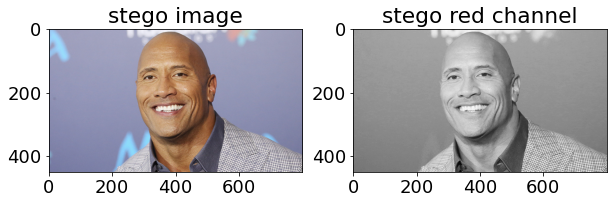

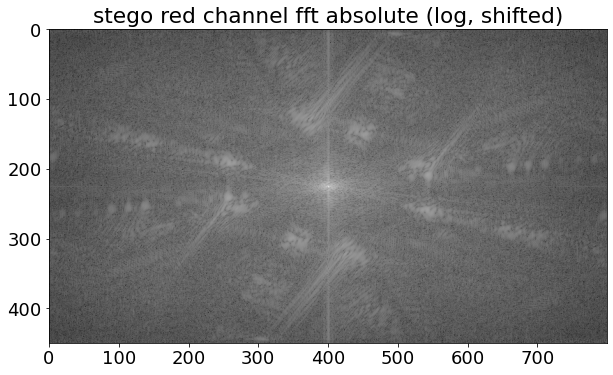

In [5]:
# load and plot image
stego_img = Image.open("ImageSources\\Steganograms\\remerged_sharp.png")
plt.figure()
plt.subplot(121)
plt.imshow(stego_img)
plt.title("stego image")

stego_r, stego_g, stego_b = stego_img.split() #split image into its RGB channels

plt.subplot(122)
plt.imshow(stego_r, cmap="gray")
plt.title("stego red channel")

print("max value stego_r:\n", np.max(stego_r))

# transform R channel into frequency domain
stego_r_fft =np.fft.fft2(stego_r)
stego_r_fft_abs = np.abs(stego_r_fft)
stego_r_fft_abs_shift = np.fft.fftshift(stego_r_fft_abs)

plt.figure()
# plt.subplot(121)
plt.imshow(20*np.log10(stego_r_fft_abs_shift), cmap="gray")
plt.title("stego red channel fft absolute (log, shifted)")


message=np.zeros(len(bin_encoded), dtype='uint16')
counter=0
#######################

for i in range(cover_rows):
    for j in range(cover_cols):
        if counter==len(bin_encoded):
            break
        print(stego_r_fft_abs_shift[i,j])
        message[counter] = stego_r_fft_abs_shift[i,j]
        counter+=1 

binary = message2bin(message, 1700)
Text = text_from_bits_int(binary)
print("bin_decoded:", Text)